In [89]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

Apple pixels:  [[0.63137255 0.70196078 0.74117647 ... 0.66666667 0.6745098  0.57254902]
 [0.42352941 0.48627451 0.51372549 ... 0.57647059 0.58431373 0.48235294]
 [0.26666667 0.33333333 0.36470588 ... 0.45490196 0.45882353 0.34901961]]
Shape of apple pixels:  (3, 142166)


Text(0.5, 1.0, 'raw_masks[0]')

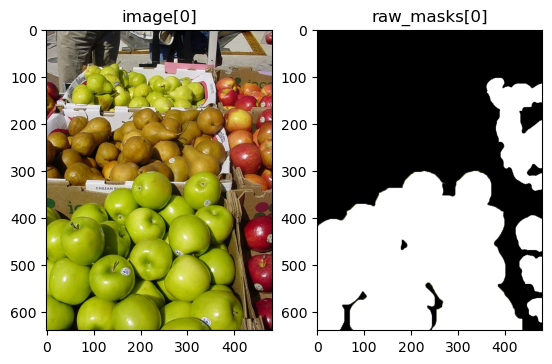

In [90]:
image_files = glob.glob("apples/*.jpg")
mask_files = glob.glob("apples/*.png")
image_files.sort()
mask_files.sort()

image_list = []
raw_masks = []
apple_pixels = []

for cur_img in image_files:
    # load images
    image = plt.imread(cur_img)
    image_list.append(image)

for cur_mask in mask_files:
    # load masks
    raw = plt.imread(cur_mask)
    if raw.shape[-1] == 4:
        raw = np.delete(raw, -1, axis=-1)
    raw_masks.append(raw)

def mask_reshape(data):
    return np.float32(data.reshape(data.shape[0] * data.shape[1], data.shape[2]))

for i in range(len(raw_masks)):
    reshaped_image = mask_reshape(image_list[i])
    reshaped_mask = mask_reshape(raw_masks[i])
    apple_red, apple_green, apple_blue = [],[],[]
    for j in range(len(reshaped_mask)):
        if reshaped_mask[j].sum() > 0: # if is masked and annotated as apple
            apple_red.append(reshaped_image[j][0] / 255)
            apple_green.append(reshaped_image[j][1] / 255)
            apple_blue.append(reshaped_image[j][2] / 255)
    apple_pixels.append(np.array([apple_red, apple_green, apple_blue]))

print("Apple pixels: ", apple_pixels[0])
print("Shape of apple pixels: ", apple_pixels[0].shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image_list[0])
ax1.set_title('image[0]')
ax2.imshow(raw_masks[0])
ax2.set_title('raw_masks[0]')

In [91]:
def getMixGaussLogLike(data, mixGaussEst):
    
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape
    # initialize log likelihoods                                                                       
    logLike = 0
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData] 
        totalLike = 0
        for current_gauss in range(mixGaussEst['k']):
            totalLike += mixGaussEst['weight'][current_gauss] * multivariate_normal.pdf(thisData, mixGaussEst['mean'][:,current_gauss], mixGaussEst['cov'][:,:,current_gauss])
        # add to total log like                                                                        
        logLike += np.log(totalLike)                                                               
                                                                                                       
    return  logLike.item()                                                                       
                                                                                                       

In [92]:
def fitMixGauss(data, k):
    nDims, nData = data.shape
    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        
    # calculate current likelihood
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))
    nIter = 10
    for cIter in range(nIter):
        # ===================== =====================
        # Expectation step
        for cData in range(nData):
            postHidden[:, cData] = np.zeros(shape=(k))
            for current_gauss in range(k):
                postHidden[current_gauss, cData] = mixGaussEst['weight'][current_gauss] * multivariate_normal.pdf(data[:,cData], mixGaussEst['mean'][:,current_gauss], mixGaussEst['cov'][:,:,current_gauss])
            postHidden[:, cData] = postHidden[:, cData] / np.sum(postHidden[:, cData])

        # ===================== =====================
        # Maximization Step
        for cGauss in range(k):
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss,:]) / np.sum(postHidden)
            mixGaussEst['mean'][:,cGauss] = np.sum(postHidden[cGauss,:] * data, axis=1) / np.sum(postHidden[cGauss,:])
            mixGaussEst['cov'][:,:,cGauss] = np.zeros(shape=(nDims, nDims))
            for current_data in range(nData):
                mixGaussEst['cov'][:,:,cGauss] += postHidden[cGauss,current_data] * np.outer(data[:,current_data] - mixGaussEst['mean'][:,cGauss], data[:,current_data] - mixGaussEst['mean'][:,cGauss])
            mixGaussEst['cov'][:,:,cGauss] /= np.sum(postHidden[cGauss,:])
            
        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))


    return mixGaussEst

In [93]:
nGaussEst = 5
testor = apple_pixels[0]
mix_gauss_estimated = fitMixGauss(testor, nGaussEst)


Log Likelihood Iter 0 : -865057.888

Log Likelihood After Iter 0 : 226322.897

Log Likelihood After Iter 1 : 267075.866

Log Likelihood After Iter 2 : 314253.454

Log Likelihood After Iter 3 : 393728.731



[[0.61840964 0.34435602 0.18873919]
 [0.57683671 0.62055554 0.06128014]
 [0.80803049 0.67682745 0.53705031]]


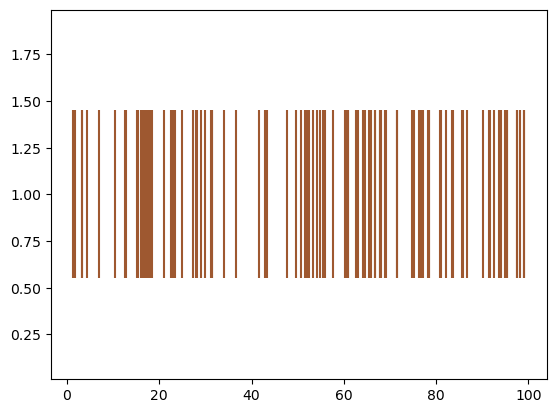

In [111]:
rgb_color_mog_mean = mix_gauss_estimated['mean'].T
print(rgb_color_mog_mean)

# plot the color
spikes = 100*np.random.random(100)

_, (ax1, ax2, ax3) = plt.subplots(1, 2)
plt.eventplot(spikes, orientation='horizontal', linelengths=0.9, color = [(rgb_color_mog_mean[0])])
# plt.eventplot(spikes, orientation='horizontal', linelengths=0.9, color = [(rgb_color_mog_mean[1])])
# plt.eventplot(spikes, orientation='horizontal', linelengths=0.9, color = [(rgb_color_mog_mean[2])])
plt.show()
